# Comentario importante
### Este cuaderno también está altamente comentado, pero más a detalle las decisiones se encuentran en el documento.

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Entendimiento de los datos

El caso de estudio es el siguiente "El Ministerio de Comercio, Industria y Turismo de Colombia, la Asociación Hotelera y
Turística de Colombia – COTELCO, cadenas hoteleras de la talla de Hilton, Hoteles Estelar,
Holiday Inn y hoteles pequeños ubicados en diferentes municipios de Colombia están
interesados en analizar las características de sitios turísticos que los hacen atractivos para
turistas locales o de otros países, ya sea para ir a conocerlos o recomendarlos. De igual
manera, quieren comparar las características de dichos sitios, con aquellos que han
obtenido bajas recomendaciones y que están afectando el número de turistas que llegan a
ellos. Adicionalmente, quieren tener un mecanismo para determinar la calificación que
tendrá un sitio por parte de los turistas y así, por ejemplo, aplicar estrategias para identificar
oportunidades de mejora que permitan aumentar la popularidad de los sitios y fomentar el
turismo."

Los datos que nos son entregados son bastante sencillos, 

In [176]:
data = pd.read_csv('tipo2_entrenamiento_estudiantes.csv')
data

,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3
...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4
7871,"Fue una escapada de un día desde el complejo, ...",4
7872,La Plaza de la Revolución es un lugar emblemát...,3
7873,Es la segunda ocasión que me quedo en los cuar...,1


In [177]:
data.shape

(7875, 2)

<AxesSubplot: ylabel='Class'>

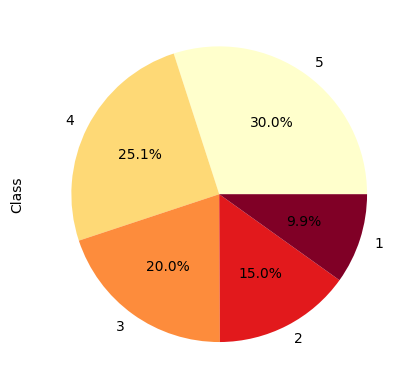

In [178]:
data["Class"].value_counts().plot(kind='pie', colormap="YlOrRd", autopct='%1.1f%%')

Aqui podemos ver la distribucion de las estrellas dadas por los usuarios, esta distribucion equitativa nos ayuda a determinar que estos datos van a ser utiles para el análisis.

In [179]:
data.isnull().any()

Review    False
Class     False
dtype: bool

Podemos ver que no existen valores nulos, ahora vamos a ver la distribucion de los datos para ver cuantas palabras hay por reseña.

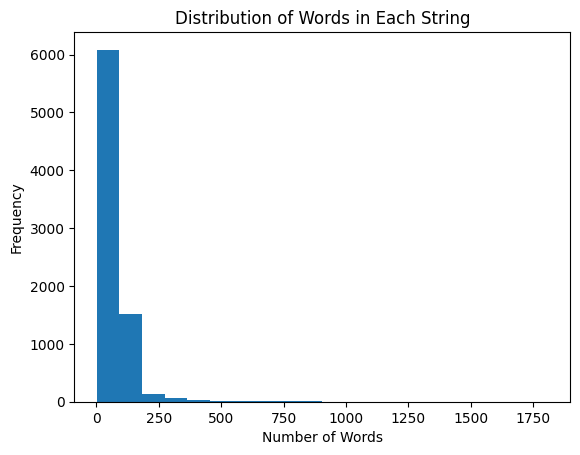

In [180]:
data['Review'].str.split().apply(len).plot(kind='hist', bins=20)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words in Each String')
plt.show()

# Preparacion de los datos

El primer paso en la preparación de los datos fue realizar una limpieza general teniendo en cuenta algunos aspectos irrelevantes como las letras tildadas y las mayúsculas. Esto tiene el propósito de eliminar palabras repetidas por algunas razones insignificativas.

In [181]:
def limpieza(data):
    data = data.str.lower()
    data = data.str.replace("á", "a").str.replace("é", "e").str.replace("í", "i").str.replace("ó", "o").str.replace("ú", "u")
    data = data.str.replace("[^a-z]", " ")
    return data

data['Review'] = limpieza(data['Review'])

data_train, data_test = train_test_split(data, test_size=0.2)
y_train, y_test = data_train["Class"], data_test["Class"]

C:\Users\Luisfetoga\AppData\Local\Temp\ipykernel_20944\1869968829.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[^a-z]", " ")


Posteriormente decimos generar un pipeline con el TfidfVectorizer.

Esta función nos ayuda en multiples aspectos, en primera instancia si los datos no están tokenizados realiza este paso, además decide contar cuantas veces aparece cada toquen y le asigna una frecuencia. Posteriormente realiza un calculo de la frecuencia inversa para poder medir y comparar ambas métricas. Teniendo en cuenta esto, el logra devolver una matriz donde cada columna es la palabra y las metricas encontradas para cada una.

In [182]:
pipeline = make_pipeline(
    TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5),
)

X_train = pipeline.fit_transform(data_train["Review"])
X_test = pipeline.transform(data_test["Review"])

# Creacion del modelo

Utilizaremos esta funcion para poder determinar las métricas de nuestros modelos y evaluar cual debería ser el que escogemos.

In [183]:
def benchmark(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    
    print("Exactitud: ", round(accuracy_score(y_test, pred), 3))
    print("Precisión: ", round(precision_score(y_test, pred, average='weighted'), 3))
    print("Recall: ", round(recall_score(y_test, pred, average='weighted'), 3))
    print("F1: ", round(f1_score(y_test, pred, average='weighted'), 3))
    

## RidgeClassifier

“Ridge Classifier”, este clasificador utiliza la regresión de Ridge. Este método Ridge permite estimar los coeficientes de modelos de regresión en múltiples escenarios donde las variables independientes están altamente correlacionadas. Aplica regularización L2 para reducir el sobreajuste en el modelo y manejar la multicolinealidad (alta correlación entre características). 

Exactitud:  0.462
Precisión:  0.451
Recall:  0.462
F1:  0.451


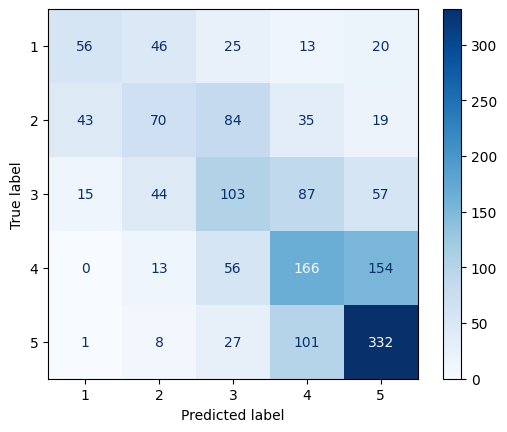

In [184]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier(tol=1e-2, solver="sparse_cg")
benchmark(ridge, X_train, y_train, X_test, y_test)

## Logistic Regression

“Logistic Regression”, este es un modelo estadístico que modela las variables con coeficientes para cada característica (estos coeficientes se estiman utilizado la información de entreno), luego realiza unos cálculos de la suma ponderada de los coeficientes encontrados, para luego pasarlos por una función lógica y producir valores de 0 a 1 (que determina la probabilidad de la instancia estar en la categoría). Posteriormente, dependiendo del número resultado de cada categoría se determina si el acumulado de elementos cumplen con el valor predicho. 

Exactitud:  0.484
Precisión:  0.476
Recall:  0.484
F1:  0.475


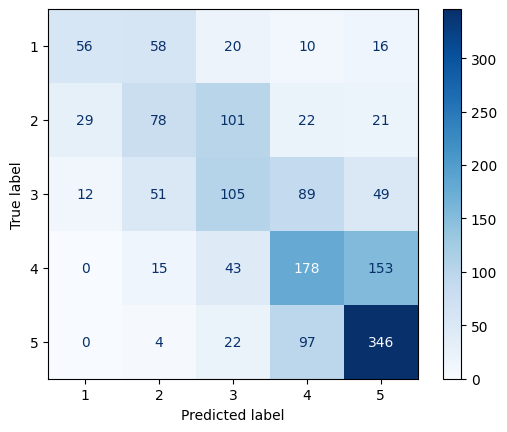

In [185]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1000)
benchmark(logistic, X_train, y_train, X_test, y_test)

“ComplementNB”, este modelo es una adaptación del algoritmo MNB (multinomial naive Bayes) que es usado para data sets no balanceados. Este modelo logra determinar valores más adecuados cuando los datos estan más sesgados hacia una dirección. 


## Complement NB

Exactitud:  0.487
Precisión:  0.468
Recall:  0.487
F1:  0.468


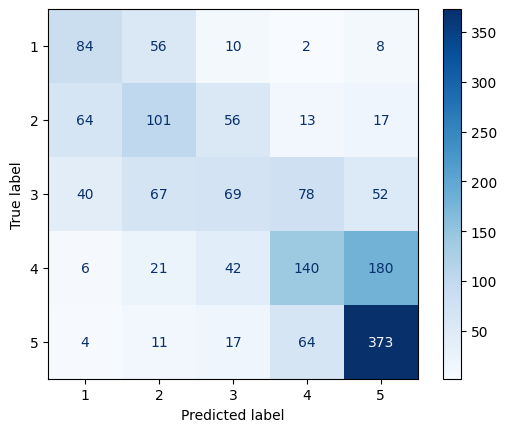

In [186]:
from sklearn.naive_bayes import ComplementNB

complement = ComplementNB()
benchmark(complement, X_train, y_train, X_test, y_test)

# Resultados

Podemos ver que los 3 algoritmos tienen valores similares para sus diferentes métricas: 

Exactitud: Esta métrica indica que porcentaje de las predicciones que realizo el modelo corresponden a la clase correcta. 

Precisión: Esta medida indica que porcentaje de las predicciones son realmente correctas. 

Recuperación: Indica el porcentaje de los casos positivos reales que el modelo detecta. 

F1-Score: Es una forma de combinar precisión y recuperación en una sola medida, por lo que nos resulta útil cuando necesitamos un equilibrio entre estas 2 métricas. 

Al analizar los resultados de los algoritmos Ridge Classifier, Logistic Regression y Complement NB, se observa que presentan valores similares en términos de exactitud, precisión, recuperación y F1-Score. Esto sugiere que no hay diferencias significativas en el desempeño entre estos tres algoritmos para este problema en específico. 

	Sin embargo, encontramos que el modelo que mejor se acerca a lo que buscamos es el Logistic Regression 

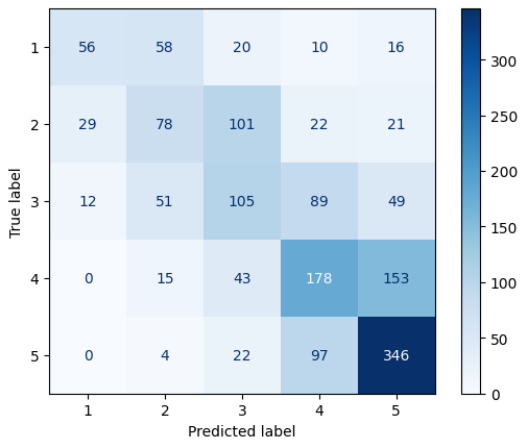

# Etiquetación de Datos

Aqui vamos a realizar un trabajo de etiquetación de los datos para poder determinar que tan correcto fue nuestro modelo.

In [195]:
datos_prueba = pd.read_csv('particion_prueba_estudiantes.csv')

datos_prueba['Review'] = limpieza(datos_prueba['Review'])
X_prueba = pipeline.transform(datos_prueba["Review"])

clf = LogisticRegression(max_iter=1000)
pred_prueba = logistic.predict(X_prueba)

datos_prueba["Class"] = pred_prueba
datos_prueba.to_csv('particion_prueba_estudiantes_etiquetados.csv', index=False)

C:\Users\Luisfetoga\AppData\Local\Temp\ipykernel_20944\1869968829.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[^a-z]", " ")
